<a href="https://colab.research.google.com/github/seenu-g/eva4-2/blob/master/week2/experiment/EVA4_S2_mobilnet_v2_transfer_learning_v4c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. **Prepare Environment: Libraries**

In [ ]:
 pip install torch-lr-finder 

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode

**Prepare Environment: Mount Drive, Get code from Github and images from Google Drive**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
!rm -rf final_images
!wget -q https://github.com/EVA4-RS-Group/Phase2/releases/download/s2/final_images.zip
!unzip -q final_images.zip
!rm -rf /content/__MACOSX
!find /content/final_images/data -name '.DS_Store' -type f -delete

In [5]:
# Load modules/models from EVA course
!rm -rf Modules
!git clone https://github.com/EVA4-RS-Group/Phase2 -q --quiet
!mv ./Phase2/Modules ./Modules
!rm -rf Phase2
#print("Loaded EVA4 Modules")
from Modules import *

  pip install torch-lr-finder -v --global-option="amp"


**Calculate Mean and Standard Deviation**

In [6]:
import os
#calculate STd and Mean
from tqdm import notebook
from PIL import Image
import numpy as np

n = 0
s = np.zeros(3)
sq = np.zeros(3)

data_dir = os.chdir(r"/content/final_images/data") 
image_folders = os.listdir()
print(image_folders)

for sub_dir in image_folders :
    temp = "/content/final_images/data/" + sub_dir
    image_dir = next(os.walk(temp))[2]
    file_count = 0
    for image_name in os.listdir(temp):
        file_count = file_count + 1
        if image_name.endswith(".jpg"): 
          img = Image.open("/content/final_images/data/" + sub_dir +"/" +image_name)
          x = np.array(img)/255
          s += x.sum(axis=(0,1))
          sq += np.sum(np.square(x), axis=(0,1))
          n += x.shape[0]*x.shape[1]
          continue
    print(len(image_dir), file_count)
mean = s/n
std_deviation = np.sqrt((sq/n - np.square(mean)))
print(mean, sq/n, std_deviation, n)
      

['Flying Birds', 'Large QuadCopters', 'Winged Drones', 'Small QuadCopters']
6761 6761
4165 4165
5673 5673
3653 3653
[0.54042735 0.59178285 0.62187143] [0.3688657  0.41655318 0.47662113] [0.27713531 0.25757763 0.29982837] 2243953099


# 2. Load Data & Set Data Loaders
We will use torchvision and torch.utils.data packages for loading the data.

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

In [7]:
from Modules import *

In [8]:
split_test_train_data('/content/final_images/data', tstRatio = 0.3)

['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones', 'testData.csv', 'trainData.csv']
6761
4165
3653
5673
0
0


In [9]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.54042735, 0.59178285, 0.62187143],[0.27713531, 0.25757763, 0.29982837])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.54042735, 0.59178285, 0.62187143],[0.27713531, 0.25757763, 0.29982837])
    ]),
}

# data_dir = 'hymenoptera_data'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}
#  = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=30,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

trnTransform = data_transforms['train'] 
trainSet = DroneDataset(train=True, transform = trnTransform)

tstTransform = data_transforms['val']
testSet = DroneDataset(train= False, transform = tstTransform)

dataloaders = {'train': torch.utils.data.DataLoader(trainSet, batch_size= 192, 
                                                    shuffle=True, num_workers=4),
               'val': torch.utils.data.DataLoader(testSet, batch_size= 192,
                                          shuffle=True, num_workers=4)}

dataset_sizes = {'train': len(trainSet),
                 'val':len(testSet)}

class_names = trainSet.classes
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']


# 3. Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

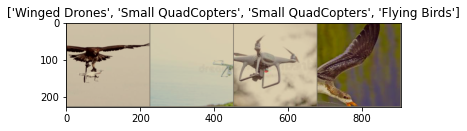

In [10]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:4,:,:,:])

imshow(out, title=[class_names[int(x)] for x in classes[0:4]])

#6. Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


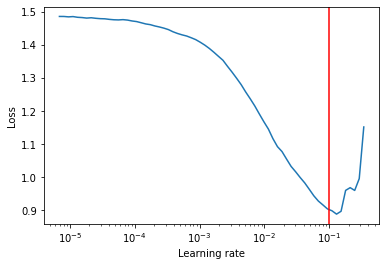

In [11]:
import torch.optim as optim
#from torch_lr_finder import LRFinder

model_ft = models.mobilenet_v2(pretrained=True)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_ft.classifier[1] = nn.Linear(1280, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_ft.classifier[1].parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_ft, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.1) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [12]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.classifier[1].parameters(), lr=0.1, momentum=0.9)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=0.1, 
                                          steps_per_epoch=len(dataloaders['train']), #Training folder size/bs 
                                          epochs=25)

# 7. Train and evaluate
It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [13]:
model_res, plotData = train_model(model_ft, dataloaders, dataset_sizes, device, criterion, optimizer_ft, scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 2.6044 Acc: 0.6807
val Loss: 2.0187 Acc: 0.7364

Epoch 1/24
----------
train Loss: 1.5700 Acc: 0.7229
val Loss: 0.9134 Acc: 0.7932

Epoch 2/24
----------
train Loss: 1.2984 Acc: 0.7304
val Loss: 0.7669 Acc: 0.7924

Epoch 3/24
----------
train Loss: 1.4720 Acc: 0.7194
val Loss: 1.1119 Acc: 0.7739

Epoch 4/24
----------
train Loss: 1.3495 Acc: 0.7199
val Loss: 1.3166 Acc: 0.7532

Epoch 5/24
----------
train Loss: 1.6045 Acc: 0.7156
val Loss: 2.0872 Acc: 0.6965

Epoch 6/24
----------
train Loss: 1.6615 Acc: 0.7194
val Loss: 0.8970 Acc: 0.8013

Epoch 7/24
----------
train Loss: 1.2147 Acc: 0.7346
val Loss: 0.6707 Acc: 0.8169

Epoch 8/24
----------
train Loss: 1.1223 Acc: 0.7283
val Loss: 0.8147 Acc: 0.7929

Epoch 9/24
----------
val Loss: 0.7323 Acc: 0.8021

Epoch 10/24
----------
train Loss: 1.3996 Acc: 0.7106
val Loss: 1.1531 Acc: 0.7792

Epoch 11/24
----------
train Loss: 1.1767 Acc: 0.7350
val Loss: 1.5872 Acc: 0.7216

Epoch 12/24
----------
train Loss: 1.2527 Acc: 0.7281
v

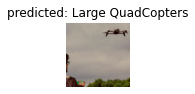

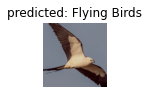

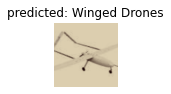

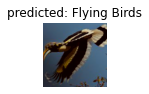

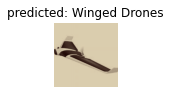

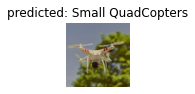

In [14]:
visualize_model(model_res, dataloaders, class_names, device)

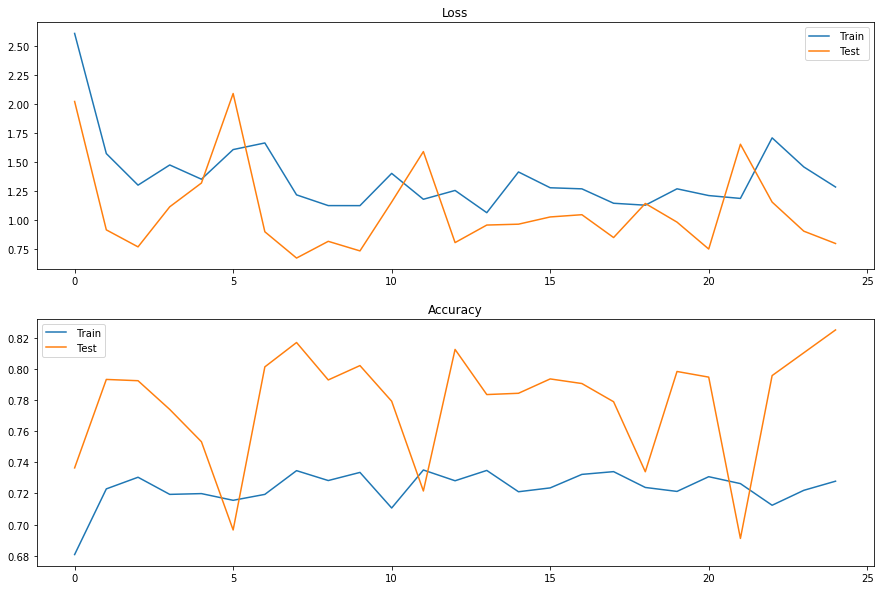

In [15]:
PlotGraph(plotData)

# 8. ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here.

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


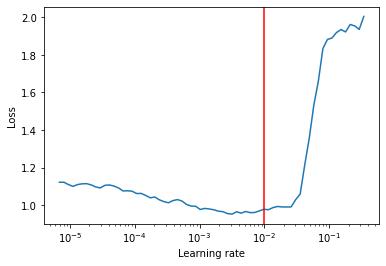

In [16]:
model_conv = model_res
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_conv = model_conv.to(device)

for param in model_conv.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_conv.parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_conv, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.01) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [17]:
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = optim.lr_scheduler.OneCycleLR(optimizer_conv,
                                          max_lr=0.01, 
                                          steps_per_epoch=len(dataloaders['train']), #Training folder size/bs
                                          epochs=25)

In [18]:
model_final, plotData = train_model(model_conv, dataloaders, dataset_sizes, device, criterion, optimizer_conv, scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8907 Acc: 0.7531
val Loss: 0.4904 Acc: 0.8329

Epoch 1/24
----------
train Loss: 0.6075 Acc: 0.7836
val Loss: 0.4031 Acc: 0.8449

Epoch 2/24
----------
train Loss: 0.5117 Acc: 0.8044
val Loss: 0.3969 Acc: 0.8483

Epoch 3/24
----------
train Loss: 0.4548 Acc: 0.8217
val Loss: 0.3584 Acc: 0.8617

Epoch 4/24
----------
train Loss: 0.4110 Acc: 0.8357
val Loss: 0.3694 Acc: 0.8623

Epoch 5/24
----------
train Loss: 0.3892 Acc: 0.8452
val Loss: 0.3314 Acc: 0.8730

Epoch 6/24
----------
train Loss: 0.3678 Acc: 0.8559
val Loss: 0.3349 Acc: 0.8788

Epoch 7/24
----------
train Loss: 0.3521 Acc: 0.8646
val Loss: 0.3280 Acc: 0.8788

Epoch 8/24
----------
train Loss: 0.3487 Acc: 0.8643
val Loss: 0.3335 Acc: 0.8819

Epoch 9/24
----------
train Loss: 0.3252 Acc: 0.8735
val Loss: 0.3407 Acc: 0.8861

Epoch 10/24
----------
train Loss: 0.3163 Acc: 0.8781
val Loss: 0.3288 Acc: 0.8823

Epoch 11/24
----------
train Loss: 0.3053 Acc: 0.8793
val Loss: 0.3301 Acc: 0.8851

Ep

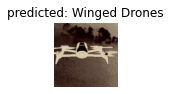

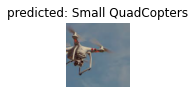

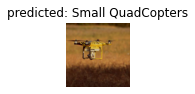

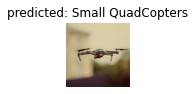

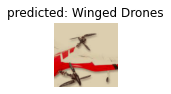

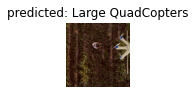

In [19]:
visualize_model(model_final, dataloaders, class_names, device)

plt.ioff()
plt.show()

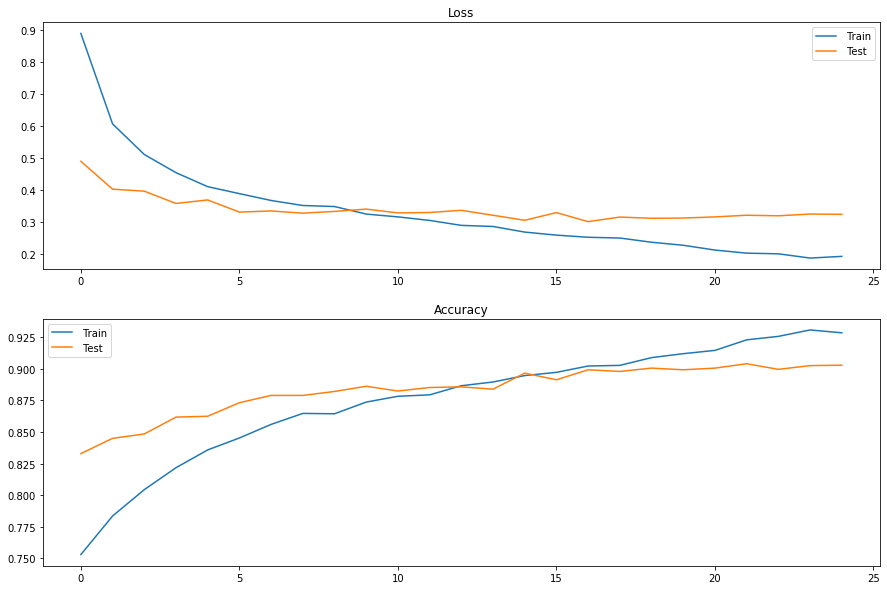

In [20]:
PlotGraph(plotData)

# 9. Saving Model

In [21]:
# Save GPU Model
torch.save(model_final.state_dict(), '/content/mobilenet_v2_custom_trained_gpu_v4b.pt')

# Load CPU Model
device = torch.device('cpu')
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(1280, 4)
model.load_state_dict(torch.load('/content/mobilenet_v2_custom_trained_gpu_v4b.pt',
                                 map_location=device))

# Saving Trace Model
model.eval()
# trace model with a dummy input
traced_model = torch.jit.trace(model, torch.randn(1, 3, 224, 224))
traced_model.save('mobilenet_v2_custom_trained_v4b.pt')